In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torchvision import datasets
from torchsummary import summary
#Neural Networks
import torch.nn as nn
import torch.nn.functional as F
#Visualize img
from torchvision.utils import make_grid
import time
#PLotting
import pylab as pl
#Optimizer
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [5]:
def get_device():
    return torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
get_device()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

Make base class inheriting and having all functions

In [59]:
from matplotlib.markers import MarkerStyle
class Basenet(nn.Module):


    def set_loss_function(self,learning_rt,optimizer_fn,mm):
        criterion = nn.CrossEntropyLoss()
        if optimizer_fn == "SGD":
            optimizer = optim.SGD(self.parameters(), lr=learning_rt, momentum=mm)
        elif optimizer_fn == "Adam":
            optimizer = optim.Adam(self.parameters(), lr=learning_rt)
        return criterion,optimizer
    
    
    
    def train_model(self,epochs,learning_rt=0.001,optimizer_fn = "SGD",mm=0.9):
        train_stats = []
        self.criterion,self.optimizer = self.set_loss_function(learning_rt,optimizer_fn,mm)
        criterion = self.criterion
        optimizer = self.optimizer
        self.epoch = epochs
        self.stats = []
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
        self.train()
        early_stopper = EarlyStopper(patience=2, min_delta=1)
        for epoch in range(epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            train_loss = []
            train_acc = []
            for i, train_set in enumerate(self.trainloader, 0):# get the inputs; data is a list of [inputs, labels]
                #inputs, labels = data
                inputs, labels = train_set[0].to(get_default_device()), train_set[1].to(get_default_device())
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                torch.autograd.set_detect_anomaly(True)
                #Appending sample loss to list
                train_loss.append(loss.item())
                
                # print statistics
                running_loss += loss.item()
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#                     print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item() / 2000:.3f}')
                    running_loss = 0.0
            # self.train()
            train_acc,train_loss = self.acc_and_loss(self.trainloader)
            # self.eval()
            val_acc,val_loss = self.acc_and_loss(self.valloader,"val")
            if early_stopper.early_stop(val_loss):  
              break
            # scheduler.step(val_loss)
            train_stat = {"epoch" : epoch+1,"Train_Loss" :train_loss,"Train_Acc" :train_acc,"Val_Acc": val_acc,"Val_Loss":val_loss}
            print(train_stat)
            # train_stats.append(train_stat)
            # train_stat = {"epoch" : epoch,"Train_Loss" :train_loss,"Train_Acc" :train_acc,"Val_Acc": val_acc,"Val_Loss":val_loss}
            # print(train_stat)
            train_stats.append(train_stat)
            # self.stats=train_stats
            # if epoch>0:
            #   print("went here at: ",epoch)
            #   if (epoch<epoch-1):
            #     print("if went here at: ",epoch)
            #     self.plot_graph(epoch)
            #   else:
            #     print("else went here at: ",epoch)
            #     self.plot_graph(epoch,last_plot= True)
        self.stats=train_stats
        print('Finished Training')
#         return True

    def imshow(self,img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        # plt.show()
    def acc_and_loss(self,loader,flag = 'train'):
        if flag == 'train':
          print("train")
          self.train()
        else:
          print("Val")
          self.eval()
        losses = []
        acc_lst = []
        mean_loss,acc = 0,0
        lbl_sz =0
        criterion = self.criterion
        optimizer = self.optimizer
        #NO gradient required as not training
        with torch.no_grad():
            for i, data in enumerate(loader, 0):
                # get the inputs
                inputs, labels = data[0].to(get_default_device()), data[1].to(get_default_device())
                outputs = self(inputs)
                #Accuracy
                lbl_sz+=labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                itm = (predicted == labels).sum().item()
                acc_lst.append(itm)
                #losses
                loss = criterion(outputs, labels)
                losses.append(loss.item())
        mean_loss = np.mean(losses)
        acc=(100 * np.sum(acc_lst) / lbl_sz)
        return  acc,mean_loss
    def Accuracy(self,flag):
        if flag == 'val':
          print("val")
          loader = self.valloader
        else:
          print("test")
          loader = self.testloader
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in loader:
                images, labels = data[0].to(get_default_device()), data[1].to(get_default_device())
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the {len(loader)} images: %d %%' % (
            100 * correct / total))
        return (100 * correct / total)
    
    # def Testing(self,flag):
    #     dataiter = iter(loader)
    #     images, labels = dataiter.next()
    #     # print images
    #     self.imshow(self,torchvision.utils.make_grid(images))
    #     print('GroundTruth: ', ' '.join(f'{self.classes[labels[j]]:5s}' for j in range(4)))

    def class_Acc(self,flag='val'):
        if flag == 'val':
          print("val")
          loader = self.valloader
        else:
          print("test")
          loader = self.testloader
        self.eval()
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with torch.no_grad():
            for data in loader:
                images, labels = data[0].to(get_default_device()), data[1].to(get_default_device())
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        for i in range(10):
            print('Accuracy of %5s : %2d %%' % (
                self.classes[i], 100 * class_correct[i] / class_total[i]))
            
    # # helper function to un-normalize and display an image        
    def show_image(self,loader):
        img, label = loader
        print('Label: ', self.classes[label], "("+str(label)+")")
        plt.imshow(img.permute(1,2,0))
        
    def show_graph(self):
        train_accuracies = [x['Train_Acc'] for x in self.stats]
        val_accuracies = [x['Val_Acc'] for x in self.stats]  
        train_losses = [x['Train_Loss'] for x in self.stats]
        val_losses = [x['Val_Loss'] for x in self.stats] 
        #Loss Graph
        plt.figure(figsize=(5, 4))
        plt.title("Plotting Training/Validation Loss vs Epochs")
        plt.plot(np.arange(self.epoch), val_losses, label = "Validation Loss")
        plt.plot(np.arange(self.epoch), train_losses, label = "Training Loss")
        plt.legend()
        plt.show()
        #Accuracy Graph
        plt.figure(figsize=(5, 4))
        plt.title("Plotting Training/Validation Accuracy  vs Epochs")
        plt.plot(np.arange(self.epoch), val_accuracies, label = "Validation Accuracy")
        plt.plot(np.arange(self.epoch), train_accuracies, label = "Training Accuracy")
        plt.legend()
        plt.show()

    def plot_graph(self,x,last_plot= False):
      train_accuracies = [x['Train_Acc'] for x in self.stats]
      val_accuracies = [x['Val_Acc'] for x in self.stats]  
      train_losses = [x['Train_Loss'] for x in self.stats]
      val_losses = [x['Val_Loss'] for x in self.stats] 
      x = np.arange(x)
      pl.close()
      pl.figure(figsize=(5, 4))
      markersize = 4
      # if last_plot:
      #   pl.xlim(min(x),max(x)+0.2)
      # else:
      #   pl.xlim(min(x),self.epoch+0.2)
      # pl.ylim((0,2))
      print(x,train_accuracies)
      pl.plot(x,train_accuracies,color = 'red',linestyle = '--',marker = 'x',markersize = markersize)
      pl.plot(x,val_accuracies,color = 'blue',linestyle = '--',marker = 'x',markersize = markersize)
      pl.plot(x,train_losses,color = 'green',linestyle = '--',marker = 'x',markersize = markersize)
      pl.plot(x,val_losses,color = 'yellow',linestyle = '--',marker = 'x',markersize = markersize)
      pl.grid(color ='black',linestyle='--',linewidth=0.5)
      pl.legend(['Training Accuracy','Validation Accuracy','Training Loss','Validaion Loss'])
      pl.xlabel('Epochs')
      pl.title('Stats Visual')
      display.clear_output(wait=True)
      display.display(pl.gcf())
      time.sleep(0.1)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Show Images in datset

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000


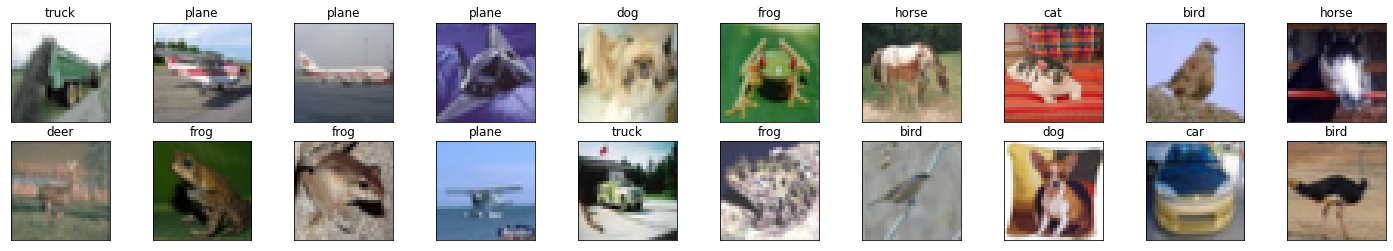

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
shimg = Imagenet_model1()


# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# # obtain one batch of training images
dataiter = iter(shimg.trainloader)
images, labels = dataiter.next()
# images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  shimg.imshow(images[idx])
  ax.set_title(shimg.classes[labels[idx]])

Model 1 - Basic CNN/FCNN structure 

In [16]:
class Imagenet_model1(Basenet):
    def __init__(self,dataset="CIFAR10",batch=32,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.shapes = False
        #CNN Layer 1
        self.conv1 = nn.Conv2d(3, 6, 5)
        # self.batchnorm1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        #CNN Layer 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        # self.batchnorm2 = nn.BatchNorm2d(16)
        #FCNN Layer 1
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #FCNN Layer 2
        self.fc2 = nn.Linear(120, 84)
        # self.batchnorm3 = nn.BatchNorm1d(84)
        #FCNN LAyer 3
        self.fc3 = nn.Linear(84, 10)
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        

        # #Regularization Parameters
        # self.dropout2d = nn.Dropout2d()
        # self.dropout1d = nn.Dropout1d()

        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=transform)
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=transform)
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):
        if self.shapes:
            print("Initial x shape ", x.shape)

        #CNN Layer 1
        x = self.conv1(x)
        # x = self.batchnorm1(x)
        x = F.relu(x)
        if self.shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.shapes:
            print('After conv1, shape of x is ', x.shape)
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.dropout2d(x)

        #CNN Layer 2
        x = self.conv2(x)
        # x = self.batchnorm2(x)
        x = F.relu(x)
        if self.shapes:
            print('After conv2, shape of x is ', x.shape)
        x = self.pool(x)
        if self.shapes:
            print('After conv2, shape of x is ', x.shape)
        # x = self.dropout2d(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        #FCNN Layer 1
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout1d(x)

        #FCNN Layer 2
        x = self.fc2(x)
        # x = self.batchnorm3(x)
        x = F.relu(x)
        
        #LAst Linear Layer
        x = self.fc3(x)
        return x
# !nvidia-smi
temp = Imagenet_model1().to(get_default_device())
summary(temp, (3, 32, 32))

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
------------------------------

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
train
Val
{'epoch': 1, 'Train_Loss': 1.4533647745132445, 'Train_Acc': 47.175, 'Val_Acc': 46.62, 'Val_Loss': 1.482877562411677}
train
Val
{'epoch': 2, 'Train_Loss': 1.3147672578334808, 'Train_Acc': 52.705, 'Val_Acc': 50.48, 'Val_Loss': 1.3760405479909512}
Finished Training


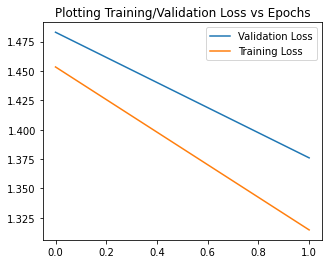

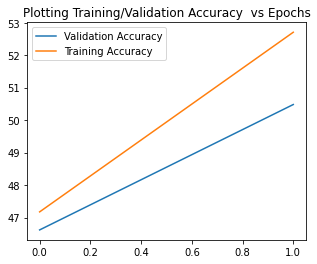

In [19]:
#BAtch 20 2 Batch Norms 1-CNN(on 2nd one), 1-FCNN,1 dropout - 2nd cnn
model1 = Imagenet_model1()
model1=model1.to(get_default_device())
#train_model(self,epochs,learning_rt=0.001,optimizer_fn = "SGD",mm=0.9)
model1.train_model(2,0.01,"SGD")
model1.show_graph()# batch - 4|'Train_Acc': 39.9925, 'Val_Acc': 39.25||batch 15 'Train_Acc': 47.38, 'Val_Acc': 46.93,|| batch -32 'Train_Acc': 49.2825, 'Val_Acc': 47.89 ||

In [30]:
model1.class_Acc("val")
# model1.Accuracy("val")

val
Accuracy of plane : 58 %
Accuracy of   car : 66 %
Accuracy of  bird : 45 %
Accuracy of   cat : 15 %
Accuracy of  deer : 28 %
Accuracy of   dog : 55 %
Accuracy of  frog : 79 %
Accuracy of horse : 58 %
Accuracy of  ship : 32 %
Accuracy of truck : 54 %


AttributeError: ignored

MOdel 2

In [22]:
class Imagenet_model2(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.batchnorm3 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        

        #Regularization Parameters
        self.dropout2d = nn.Dropout2d()
        self.dropout1d = nn.Dropout1d()

        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=transform)
#             trainset = torchvision.datasets.CIFAR10(root=path, train=True,
#                                                     download=True, transform=transform)
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=transform)
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):
        #CNN Layer 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.pool(x)
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.dropout2d(x)

        #CNN Layer 2
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout2d(x)


        #FCNN layer 1
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout1d(x)

        #FCNN layer 2
        x = self.fc2(x)
        x = self.batchnorm3(x)
        x = F.relu(x)

        #FCNN layer 3
        x = self.fc3(x)

        #Linear Layer
        x = self.softmax(x)
        return x
temp = Imagenet_model2().to(get_default_device())
summary(temp, (3, 32, 32))

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
       BatchNorm2d-5           [-1, 16, 10, 10]              32
         MaxPool2d-6             [-1, 16, 5, 5]               0
         Dropout2d-7             [-1, 16, 5, 5]               0
            Linear-8                  [-1, 120]          48,120
            Linear-9                   [-1, 84]          10,164
      BatchNorm1d-10                   [-1, 84]             168
           Linear-11                   [-1, 10]             850
          Softmax-12    

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 2.181
train
Val
{'epoch': 1, 'Train_Loss': 2.1140726913349166, 'Train_Acc': 34.13, 'Val_Acc': 40.34, 'Val_Loss': 2.059138463891071}
[2,  2000] loss: 2.065
train
Val
{'epoch': 2, 'Train_Loss': 2.1223268686361783, 'Train_Acc': 33.0575, 'Val_Acc': 43.27, 'Val_Loss': 2.0324609100907995}
[3,  2000] loss: 1.998
train
Val
{'epoch': 3, 'Train_Loss': 2.1128197518635834, 'Train_Acc': 33.765, 'Val_Acc': 47.81, 'Val_Loss': 1.9854161249644038}
[4,  2000] loss: 1.961
train
Val
{'epoch': 4, 'Train_Loss': 2.113100668889644, 'Train_Acc': 33.77, 'Val_Acc': 49.72, 'Val_Loss': 1.973561196491636}
[5,  2000] loss: 1.931
train
Val
{'epoch': 5, 'Train_Loss': 2.109242358366827, 'Train_Acc': 34.3825, 'Val_Acc': 51.48, 'Val_Loss': 1.9533807923947495}
Finished Training


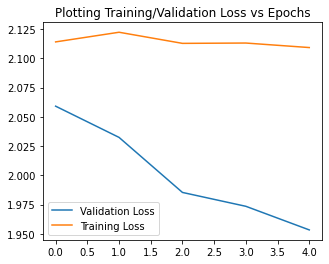

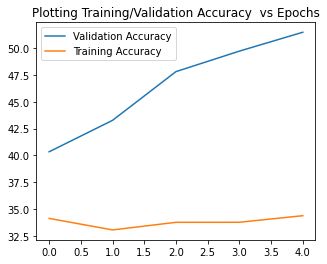

In [23]:
#Just adding SOftmax
model2 = Imagenet_model2()
model2=model2.to(get_default_device())
model2.train_model(5,0.01,"SGD")
model2.show_graph()


In [24]:
model2.class_Acc("val")
# model2.Accuracy("val")

val
Accuracy of plane : 43 %
Accuracy of   car : 61 %
Accuracy of  bird : 38 %
Accuracy of   cat : 55 %
Accuracy of  deer : 47 %
Accuracy of   dog : 33 %
Accuracy of  frog : 67 %
Accuracy of horse : 49 %
Accuracy of  ship : 72 %
Accuracy of truck : 51 %


In [51]:
class Imagenet_model3(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.shapes = False
        #CNN Layer 1
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        #CNN Layer 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        #FCNN Layer 1
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        #FCNN Layer 2
        self.fc2 = nn.Linear(120, 84)

        #FCNN LAyer 3
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        

        # #Regularization Parameters
        self.dropout2d = nn.Dropout2d(.2)
        self.dropout1d = nn.Dropout1d(.5)

        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=transform)
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=transform)
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):
        if self.shapes:
            print("Initial x shape ", x.shape)

        #CNN Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        if self.shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.shapes:
            print('After conv1, shape of x is ', x.shape)

        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.dropout2d(x)

        #CNN Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        if self.shapes:
            print('After conv2, shape of x is ', x.shape)
        x = self.pool(x)
        if self.shapes:
            print('After conv2, shape of x is ', x.shape)
        # x = self.dropout2d(x)

        # flatten all dimensions except batch
        x = torch.flatten(x, 1) 

        #FCNN Layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1d(x)

        #FCNN Layer 2
        x = self.fc2(x)
        # x = self.batchnorm3(x)
        x = F.relu(x)
        # x = self.dropout1d(x)
        #LAst Linear Layer
        x = self.fc3(x)
        x = self.softmax(x)
        return x
# !nvidia-smi
temp = Imagenet_model3().to(get_default_device())
summary(temp, (3, 32, 32))

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
         Dropout1d-6                  [-1, 120]               0
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
           Softmax-9                   [-1, 10]               0
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 2.280
train
Val
{'epoch': 1, 'Train_Loss': 2.2214336211555317, 'Train_Acc': 20.5575, 'Val_Acc': 30.89, 'Val_Loss': 2.1597248087043703}
[2,  2000] loss: 2.110
train
Val
{'epoch': 2, 'Train_Loss': 2.1916825583153643, 'Train_Acc': 23.7975, 'Val_Acc': 36.57, 'Val_Loss': 2.0849964016381053}
[3,  2000] loss: 2.077
train
Val
{'epoch': 3, 'Train_Loss': 2.188353446033236, 'Train_Acc': 24.24, 'Val_Acc': 38.1, 'Val_Loss': 2.074621688837054}
[4,  2000] loss: 2.091
train
Val
{'epoch': 4, 'Train_Loss': 2.28528113520722, 'Train_Acc': 14.6575, 'Val_Acc': 19.29, 'Val_Loss': 2.2679145237852607}
[5,  2000] loss: 2.228
train
Val
{'epoch': 5, 'Train_Loss': 2.291486591581195, 'Train_Acc': 14.0975, 'Val_Acc': 18.39, 'Val_Loss': 2.2771121899763505}
Finished Training


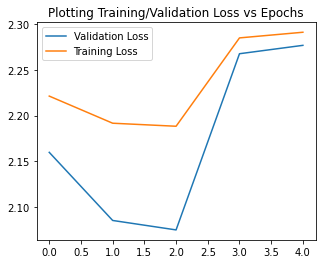

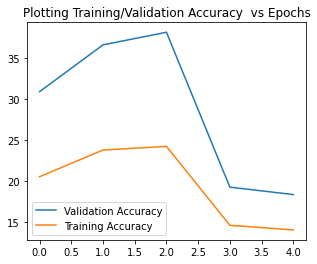

In [52]:
#Batch - 256 | Sgd |Lr = 0.005
model3 = Imagenet_model3()
model3=model3.to(get_default_device())
model3.train_model(5,0.01,"SGD")
model3.show_graph()

In [34]:
model3.class_Acc("val")
# model3.Accuracy("val")

val
Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse : 28 %
Accuracy of  ship : 97 %
Accuracy of truck :  0 %


In [62]:
class Imagenet_model4(Basenet):
    def __init__(self,dataset="CIFAR10",batch=32,path='./data',splitsize = .2):
        super().__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)
        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=transform)
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=transform)
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
temp = Imagenet_model4().to(get_default_device())
summary(temp, (3, 32, 32))

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 512]         524,800
          Dropout-11                  [-1, 512]               0
           Linear-12    

In [ ]:
model4 = Imagenet_model4()
model4=model4.to(get_default_device())
model4.train_model(15,0.001,"SGD")
model4.show_graph()

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
train
Val
{'epoch': 1, 'Train_Loss': 1.426036121749878, 'Train_Acc': 47.3925, 'Val_Acc': 50.35, 'Val_Loss': 1.3616804775719444}


In [61]:
model4.class_Acc("val")

val
Accuracy of plane : 66 %
Accuracy of   car : 74 %
Accuracy of  bird : 84 %
Accuracy of   cat : 61 %
Accuracy of  deer : 81 %
Accuracy of   dog : 47 %
Accuracy of  frog : 72 %
Accuracy of horse : 54 %
Accuracy of  ship : 89 %
Accuracy of truck : 58 %


Awesome MOdel  from https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844

class CNN(nn.Module):


Resnet -18 Transfer Learning

In [ ]:
from torchvision import models
from torchvision.models import ResNet18_Weights
class resnet_18(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.network = models.resnet18(pretrained=True)
        
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
        #                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=ResNet18_Weights.DEFAULT.transforms())
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=ResNet18_Weights.DEFAULT.transforms())
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    def forward(self,x):
      return self.network(x)
temp = resnet_18().to(get_default_device())
summary(temp, (3, 32, 32))
# print(temp)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12    

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 0.703
{'epoch': 1, 'Train_Loss': 0.25126385907556986, 'Train_Acc': 91.61, 'Val_Acc': 87.9, 'Val_Loss': 0.3554010240199125}
[2,  2000] loss: 0.231
{'epoch': 2, 'Train_Loss': 0.15348576410969683, 'Train_Acc': 94.6775, 'Val_Acc': 89.56, 'Val_Loss': 0.3118012480757505}
[3,  2000] loss: 0.130
{'epoch': 3, 'Train_Loss': 0.08110631237969443, 'Train_Acc': 97.3525, 'Val_Acc': 90.54, 'Val_Loss': 0.2903403858420323}
[4,  2000] loss: 0.079
{'epoch': 4, 'Train_Loss': 0.05281313419424556, 'Train_Acc': 98.2525, 'Val_Acc': 91.34, 'Val_Loss': 0.27427512042296315}
[5,  2000] loss: 0.053
{'epoch': 5, 'Train_Loss': 0.03953851285087688, 'Train_Acc': 98.7525, 'Val_Acc': 91.82, 'Val_Loss': 0.2700732319842329}
Finished Training


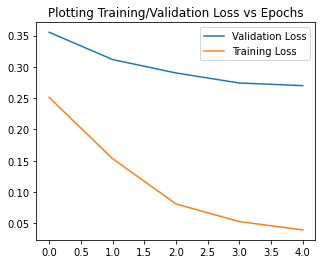

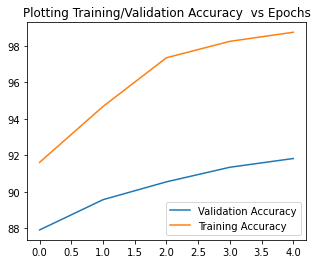

In [ ]:
model_resnet = resnet_18()
# num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(512, 10)
model_resnet=model_resnet.to(get_default_device())
model_resnet.train_model(5,0.001,"SGD")
model_resnet.show_graph()

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 1.061
{'epoch': 1, 'Train_Loss': 0.6359418182713086, 'Train_Acc': 78.8475, 'Val_Acc': 76.39, 'Val_Loss': 0.7106073419305159}
[2,  2000] loss: 0.607
{'epoch': 2, 'Train_Loss': 0.5238158674718604, 'Train_Acc': 81.725, 'Val_Acc': 77.71, 'Val_Loss': 0.6672342979590753}
[3,  2000] loss: 0.463
{'epoch': 3, 'Train_Loss': 0.32175970903832085, 'Train_Acc': 89.415, 'Val_Acc': 83.15, 'Val_Loss': 0.5014312873068063}
[4,  2000] loss: 0.338
{'epoch': 4, 'Train_Loss': 0.22959344846974844, 'Train_Acc': 92.245, 'Val_Acc': 84.62, 'Val_Loss': 0.47166903088542295}
[5,  2000] loss: 0.249
{'epoch': 5, 'Train_Loss': 0.17032020651671811, 'Train_Acc': 94.075, 'Val_Acc': 85.11, 'Val_Loss': 0.48425732034983215}
Finished Training


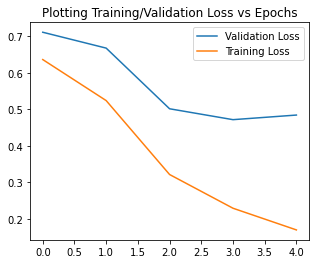

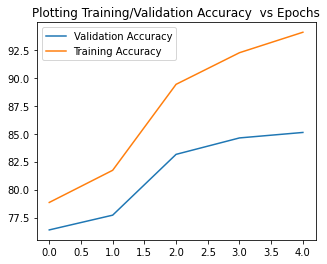

In [ ]:
model_resnet_A = resnet_18()
# num_ftrs = model_resnet.fc.in_features
model_resnet_A.fc = nn.Linear(512, 10)
model_resnet_A=model_resnet_A.to(get_default_device())
model_resnet_A.train_model(5,0.001,"Adam")
model_resnet_A.show_graph()

vgg 16 

In [ ]:
from torchvision import models
from torchvision.models import VGG16_Weights
class vgg_16(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.network = models.vgg16(pretrained=True)
        
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
        #                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=VGG16_Weights.DEFAULT.transforms())
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=VGG16_Weights.DEFAULT.transforms())
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    def forward(self,x):
      return self.network(x)
temp = vgg_16().to(get_default_device())
summary(temp, (3, 32, 32))
# print(temp)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
           

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 0.948
{'epoch': 1, 'Train_Loss': 0.3376458943538636, 'Train_Acc': 88.45, 'Val_Acc': 85.4, 'Val_Loss': 0.42247319060644467}
[2,  2000] loss: 0.365
{'epoch': 2, 'Train_Loss': 0.26016939480753737, 'Train_Acc': 91.02, 'Val_Acc': 86.59, 'Val_Loss': 0.3957823630969698}
[3,  2000] loss: 0.232
{'epoch': 3, 'Train_Loss': 0.11998737542935409, 'Train_Acc': 96.0025, 'Val_Acc': 90.35, 'Val_Loss': 0.2994875552131329}
[4,  2000] loss: 0.152
{'epoch': 4, 'Train_Loss': 0.1266173965078984, 'Train_Acc': 95.8325, 'Val_Acc': 89.08, 'Val_Loss': 0.3558267710463045}
[5,  2000] loss: 0.108
{'epoch': 5, 'Train_Loss': 0.07081367148333795, 'Train_Acc': 97.825, 'Val_Acc': 90.2, 'Val_Loss': 0.32045558020106873}
Finished Training


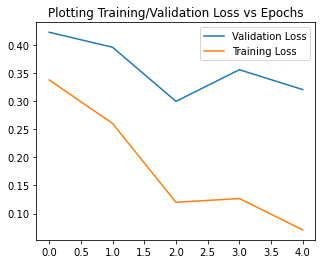

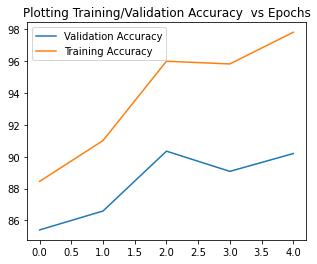

In [ ]:
model_vgg16 = vgg_16()
# num_ftrs = model_resnet.fc.in_features
model_vgg16.fc = nn.Linear(512, 10)
model_vgg16=model_vgg16.to(get_default_device())
model_vgg16.train_model(5,0.001,"SGD")
model_vgg16.show_graph()

In [ ]:
model_vgg16_A = vgg_16()
# num_ftrs = model_resnet.fc.in_features
model_vgg16_A.fc = nn.Linear(512, 10)
model_vgg16_A=model_vgg16_A.to(get_default_device())
model_vgg16_A.train_model(5,0.0001,"Adam")
model_vgg16_A.show_graph()

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 0.775
{'epoch': 1, 'Train_Loss': 0.39451621488898847, 'Train_Acc': 86.82, 'Val_Acc': 82.43, 'Val_Loss': 0.5100372812614359}
[2,  2000] loss: 0.370
{'epoch': 2, 'Train_Loss': 0.24053332731452498, 'Train_Acc': 91.9225, 'Val_Acc': 85.71, 'Val_Loss': 0.42910161925510487}
[3,  2000] loss: 0.253
{'epoch': 3, 'Train_Loss': 0.12352227720749408, 'Train_Acc': 95.9775, 'Val_Acc': 88.44, 'Val_Loss': 0.37406181148288287}
[4,  2000] loss: 0.186
{'epoch': 4, 'Train_Loss': 0.1422468361786238, 'Train_Acc': 95.4975, 'Val_Acc': 87.15, 'Val_Loss': 0.46337964629975736}


Google Net

In [ ]:
from torchvision import models
from torchvision.models import GoogLeNet_Weights
class GoogleNet(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.network = models.GoogLeNet(pretrained=True)
        
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
        #                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=VGG16_Weights.DEFAULT.transforms())
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=VGG16_Weights.DEFAULT.transforms())
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    def forward(self,x):
      return self.network(x)
temp = GoogleNet().to(get_default_device())
summary(temp, (3, 32, 32))
# print(temp)

##Showing Images

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 1.7401209400177002, 'Train_Acc': 35.19, 'Val_Acc': 35.04, 'Val_Loss': 1.7455207417948178}
{'epoch': 2, 'Train_Loss': 1.6341974850654601, 'Train_Acc': 40.58, 'Val_Acc': 39.54, 'Val_Loss': 1.6506910544995683}
{'epoch': 3, 'Train_Loss': 1.5659031383514403, 'Train_Acc': 43.065, 'Val_Acc': 42.1, 'Val_Loss': 1.5834134078254334}
{'epoch': 4, 'Train_Loss': 1.5411020215988158, 'Train_Acc': 44.495, 'Val_Acc': 43.08, 'Val_Loss': 1.5720441794623963}
{'epoch': 5, 'Train_Loss': 1.4810718903064728, 'Train_Acc': 46.055, 'Val_Acc': 44.43, 'Val_Loss': 1.5254827467397378}
Finished Training


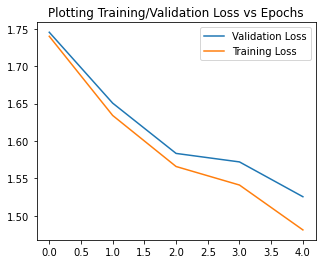

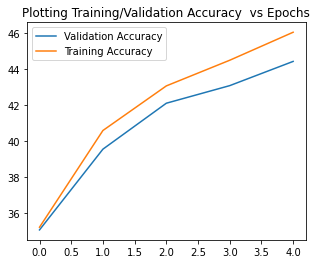

In [ ]:
#Just adding Linear dropout
model3 = Imagenet_model3()
model3=model3.to(get_default_device())
model3.train_model(5,0.01,"SGD")
model3.show_graph()

Show  Images in daatset

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 0.461
[1,  4000] loss: 0.430
[1,  6000] loss: 0.409
[1,  8000] loss: 0.429
[1, 10000] loss: 0.408
epoch :1|train loss :0.3348534572911851|train Acc :88.56|val Acc: 63.84|val Loss :1.321176587426223
[2,  2000] loss: 0.335
[2,  4000] loss: 0.328
[2,  6000] loss: 0.354
[2,  8000] loss: 0.350
[2, 10000] loss: 0.364
epoch :2|train loss :0.28240686659000325|train Acc :90.715|val Acc: 63.79|val Loss :1.395709837311288
[3,  2000] loss: 0.288
[3,  4000] loss: 0.292
[3,  6000] loss: 0.300
[3,  8000] loss: 0.316
[3, 10000] loss: 0.312
epoch :3|train loss :0.24255979586216922|train Acc :92.265|val Acc: 63.38|val Loss :1.5160076870894468
[4,  2000] loss: 0.251
[4,  4000] loss: 0.263
[4,  6000] loss: 0.264
[4,  8000] loss: 0.267
[4, 10000] loss: 0.283
epoch :4|train loss :0.21555674771110817|train Acc :93.4025|val Acc: 62.89|val Loss :1.60501

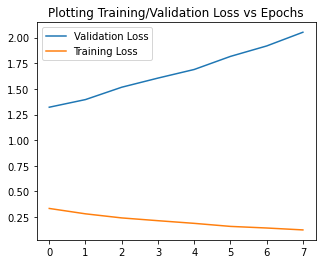

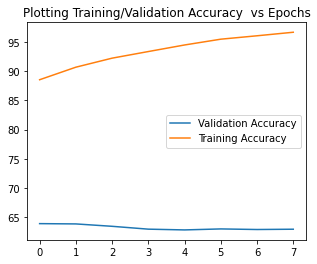

In [ ]:
model3 = Imagenet()
model3=model1.to(get_default_device())
#def train(self,epochs,learning_rt=0.001,mm=0.9,optimizer_fn = "SGD"):
model3.train(8,0.0001,"Adam")#0.0001
model2.show_graph()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 0.132
[1,  4000] loss: 0.138
[1,  6000] loss: 0.138
[1,  8000] loss: 0.159
[1, 10000] loss: 0.154
epoch :1|train loss :0.10809835489150586|train Acc :97.395|val Acc: 62.46|val Loss :2.152237065738473
[2,  2000] loss: 0.108
[2,  4000] loss: 0.116
[2,  6000] loss: 0.122
[2,  8000] loss: 0.137
[2, 10000] loss: 0.140
epoch :2|train loss :0.09286956598169807|train Acc :97.8625|val Acc: 62.34|val Loss :2.282766452961451
[3,  2000] loss: 0.096
[3,  4000] loss: 0.102
[3,  6000] loss: 0.105
[3,  8000] loss: 0.120
[3, 10000] loss: 0.113
epoch :3|train loss :0.07869688009604159|train Acc :98.21|val Acc: 62.14|val Loss :2.4736493946262934
[4,  2000] loss: 0.077
[4,  4000] loss: 0.093
[4,  6000] loss: 0.096
[4,  8000] loss: 0.099
[4, 10000] loss: 0.105
epoch :4|train loss :0.06695226490605904|train Acc :98.5825|val Acc: 62.25|val Loss :2.6032512128781127
[5,  2000] loss: 0.067
[

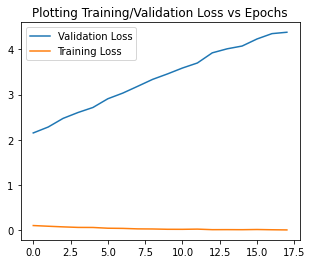

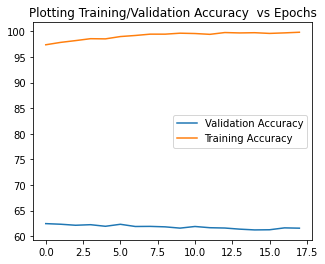

In [ ]:
model3 = Imagenet()
model3=model1.to(get_default_device())
#def train(self,epochs,learning_rt=0.001,mm=0.9,optimizer_fn = "SGD"):
model3.train(18,0.0001,"Adam")#0.0001
model2.show_graph()

In [ ]:
class PujanNet(Basenet):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__()
        torch.manual_seed(5)
        self.stats = []
        self.epoch_number = 0
        self.shapes = False
    
        transform = transforms.Compose(
            [
                #transforms.Grayscale(num_output_channels=3), # with grayscale, overfitting slightly decreased, this should be the result of data augmentation, this is not converting all images to grayscale
                
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

        if data_set_name == "cifar_10":
            dataset = torchvision.datasets.CIFAR10(root=download_path, train=True, download=True, transform=transform)
            print('Length of Dataset ', len(dataset))

            train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_data_size, validation_data_size])
            print('Length of Train set ', len(train_dataset))
            print('Length of Val set ', len(val_dataset))
            self.trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
            self.valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

            testset = torchvision.datasets.CIFAR10(root=download_path, train=False, download=True, transform=transform)
            print('Length of Testset ', len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        self.criterion = criterion
        # input channel should be 3 for color image and 1 for grayscale
        self.conv1 = nn.Conv2d(3, 6, 3)
        # https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        # mat1 and mat2 shapes cannot be multiplied (4x576 and 400x120)
        # filter = 1, input shape for linear should be 6 * 6,
        # filter = 3, 5, input shape for linear should be 5 * 5
        # self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout_2d = nn.Dropout2d()
        self.dropout_1d = nn.Dropout1d()

    def forward(self, x):
        if self.shapes:
            print("Initial x shape ", x.shape)
        # x = self.pool(F.relu(self.conv1(x)))
        # print("After conv1 and maxpool, x shape ", x.shape)

        # First layer
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        if self.shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.shapes:
            print('After max pool 1, shape of x is ', x.shape)
        
        # dropout
        # x = self.dropout_2d(x)
        if self.shapes:
            print('Shape after dropout after conv layer 1 ', x.shape) 
        # Second layer
        # x = self.pool(F.relu(self.conv2(x)))
        # print("After conv2 and maxpool, x shape ", x.shape)

        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.dropout_2d(x)
        if self.shapes:
            print('After conv2, shape of X is ', x.shape)
        x = self.pool(x)
        if self.shapes:
            print('After max pool 2, shape of x is ', x.shape)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        if self.shapes:
            print('After flatten, x shape ', x.shape)

        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = F.relu(x)
        if self.shapes:
            print('After fc1, x shape ', x.shape)

        x = self.fc2(x)
        x = F.relu(x)
        if self.shapes:
            print('After fc2, x shape ', x.shape)
        x = self.fc3(x)
        if self.shapes:
            print('After fc3, x shape ', x.shape)
        return x


Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
{'epoch': 0, 'Train_Loss': 2.006696618843079, 'Train_Acc': 27.78, 'Val_Acc': 33.43, 'Val_Loss': 1.9679253473403349}
{'epoch': 1, 'Train_Loss': 1.9761597478866577, 'Train_Acc': 28.66, 'Val_Acc': 37.31, 'Val_Loss': 1.8838635986777628}
{'epoch': 2, 'Train_Loss': 1.992767588043213, 'Train_Acc': 28.81, 'Val_Acc': 40.57, 'Val_Loss': 1.8121617075743948}
{'epoch': 3, 'Train_Loss': 2.0300695779800413, 'Train_Acc': 28.2025, 'Val_Acc': 42.77, 'Val_Loss': 1.7565796800479767}
{'epoch': 4, 'Train_Loss': 2.0990071449279784, 'Train_Acc': 27.945, 'Val_Acc': 43.62, 'Val_Loss': 1.7327579502846784}
Finished Training


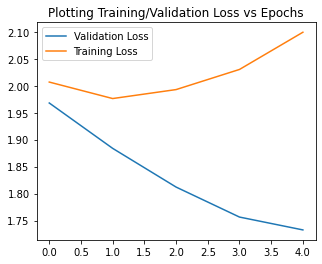

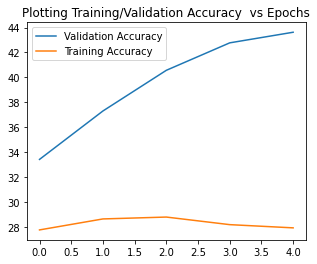

In [ ]:
criterion = nn.CrossEntropyLoss()
model_P = PujanNet(data_set_name = "cifar_10", batch_size = 64, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
model_P=model_P.to(get_default_device())
#def train(self,epochs,learning_rt=0.001,mm=0.9,optimizer_fn = "SGD"):
# model_P.train(5,0.001,"Adam")#0.0001
# model_P.show_graph()#'Train_Acc': 45.4075, 'Val_Acc': 45.31
model_P.train_model(5,0.001,"SGD")#0.0001
model_P.show_graph() # 'Train_Acc': 43.7425, 'Val_Acc': 43.8
# model_P.train_model(25,0.001,"Adam")#0.0001
# model_P.show_graph()#

{'epoch': 0, 'Train_Loss': 1.2293091514110566, 'Train_Acc': 56.11, 'Val_Acc': 52.59, 'Val_Loss': 1.338632341010121}
{'epoch': 1, 'Train_Loss': 1.198808199930191, 'Train_Acc': 57.4075, 'Val_Acc': 55.06, 'Val_Loss': 1.2883969299709455}
{'epoch': 2, 'Train_Loss': 1.194377490234375, 'Train_Acc': 57.4225, 'Val_Acc': 54.86, 'Val_Loss': 1.281893648278599}
{'epoch': 3, 'Train_Loss': 1.1873163534641267, 'Train_Acc': 57.975, 'Val_Acc': 54.15, 'Val_Loss': 1.2949131308272244}
{'epoch': 4, 'Train_Loss': 1.1953103123188018, 'Train_Acc': 57.19, 'Val_Acc': 54.26, 'Val_Loss': 1.2933300444112419}
{'epoch': 5, 'Train_Loss': 1.188926575422287, 'Train_Acc': 57.8975, 'Val_Acc': 54.48, 'Val_Loss': 1.2962515498883427}
{'epoch': 6, 'Train_Loss': 1.1864707315921783, 'Train_Acc': 57.735, 'Val_Acc': 54.22, 'Val_Loss': 1.2825414923052438}
{'epoch': 7, 'Train_Loss': 1.1848107779502868, 'Train_Acc': 57.885, 'Val_Acc': 53.89, 'Val_Loss': 1.3154965104005587}
{'epoch': 8, 'Train_Loss': 1.1694789078712464, 'Train_Acc': 

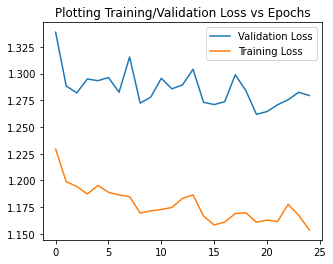

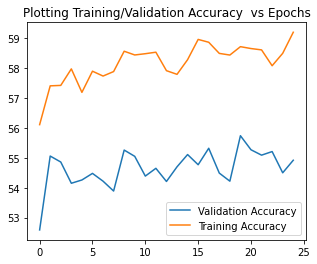

In [ ]:
model_P.train_model(25,0.001,"SGD")#0.0001
model_P.show_graph()

In [39]:
#TEMP
class Imagenet_model4(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.shapes = False
        #CNN Layer 1
        self.conv1 = nn.Conv2d(3, 16, 3,padding = 1)
        #CNN Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3,padding = 1)
        #CNN LAyer 3
        self.conv3 = nn.Conv2d(32, 64, 3,padding = 1)
        self.pool = nn.MaxPool2d(2, 2)

        #FCNN Layer 1
        self.fc1 = nn.Linear(64 * 4 * 4, 512)

        #FCNN Layer 2
        self.fc2 = nn.Linear(512, 64)

        #FCNN LAyer 3
        self.fc3 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        

        # #Regularization Parameters
        # self.dropout2d = nn.Dropout2d()
        self.dropout1d = nn.Dropout1d(.4)

        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=transform)
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=transform)
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):

        #CNN Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.dropout2d(x)

        #CNN Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        #CNN Layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)


        # x = self.dropout2d(x)

        # flatten all dimensions except batch
        # x = torch.flatten(x, 1)
        x = x.view(-1,64*4*4) 
        #FCNN Layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1d(x)

        #FCNN Layer 2
        x = self.fc2(x)
        # x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.dropout1d(x)
        #FCNN Layer 3
        x = self.fc3(x)
        # x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.dropout1d(x)

        #LAst Linear Layer
        x = self.fc3(x)
        # x = self.softmax(x)
        return x
# !nvidia-smi
temp = Imagenet_model3().to(get_default_device())
summary(temp, (3, 32, 32))

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
         Dropout2d-5             [-1, 16, 5, 5]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
           Softmax-9                   [-1, 10]               0
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 